In [88]:
# Driveマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Kaggle API

In [89]:
!pip install kaggle

In [90]:
# jsonファイルをコピーして作業スペースに持ってくる
!cp /content/drive/MyDrive/tool/key/kaggle.json /content/

# root下に移動
!mkdir -p ~/.kaggle         # -p: 親ディレクトリも含めて作成
!mv kaggle.json ~/.kaggle/

# ダウンロード
!chmod 600 /root/.kaggle/kaggle.json        # 600: 所有者のみ読み書き可能
!kaggle competitions download -c home-credit-default-risk

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
credit_card_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
bureau.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
bureau_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
HomeCredit_columns_description.csv: Skipping, found more recently modified local copy (use --force to force download)
previous_application.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
POS_CASH_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
installments_payments.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
application_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
application_test.csv

#import

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA

#データ確認

In [92]:
train = pd.read_csv('application_train.csv.zip', encoding='UTF-8')
test = pd.read_csv("/content/application_test.csv.zip", encoding='UTF-8')
print(train.shape)
print(test.shape)
train.head(3)

(307511, 122)
(48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
"""
# pyファイル開発用に出力
train = train.sample(int(len(train)/10)).reset_index().drop("index", axis=1)

train.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/train_one-tenth.csv",
    index=None
    )

test.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/test.csv",
    index=None
    )
"""

'\n# pyファイル開発用に出力\ntrain = train.sample(int(len(train)/10)).reset_index().drop("index", axis=1)\n\ntrain.to_csv(\n    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/train_one-tenth.csv",\n    index=None\n    )\n\ntest.to_csv(\n    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/test.csv",\n    index=None\n    )\n'

In [94]:
# trainとtest結合
# 実用的にはtestデータはモデル作成後に得るものなのでコンペ専用の技
df = pd.concat([train, test], ignore_index=True, sort=False)
print(df.shape)
df.head(3)

(356255, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#base_line

欠損が多すぎるため、base-lineは欠損が無い列を使用

In [95]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# SK_ID_CURR削除
df_t = df_t.drop('SK_ID_CURR', axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

# posiとnegaのサンプル数を揃える
posi = df_t[df_t["TARGET"]==1]
nega = df_t[df_t["TARGET"]==0]
test = df_t[df_t["TARGET"].isnull()]

print("返済が滞ったことがある人:", len(posi))
print("返済をしっかりしている人:", len(nega))

nega = nega.sample(len(posi), random_state=500)
print(len(nega) + len(posi) + len(test))

df_t = pd.concat([posi, nega, test])
df_t["TARGET"].isnull().sum()

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 54)
(356255, 143)
返済が滞ったことがある人: 24825
返済をしっかりしている人: 282686
98394


48744

49650


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

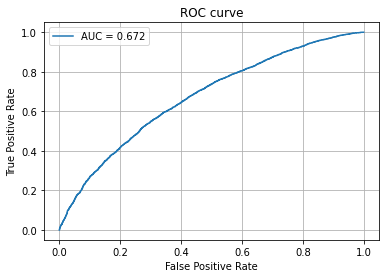

In [96]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)
print(len(tmp_train))

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression()
)

# 学習
pipe.fit(X_train, y_train)

# ROC曲線
pred = pipe.predict_proba(X_val)[:, 1]         # 1の確率だけ取り出し

fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.6227593152064451


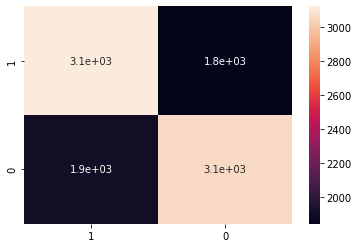

In [97]:
# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pipe.predict(X_val)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [98]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pipe.predict_proba(X_test)[:, 1]
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

#test1

In [99]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# SK_ID_CURR削除
df_t = df_t.drop('SK_ID_CURR', axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

# posiとnegaのサンプル数を揃える
posi = df_t[df_t["TARGET"]==1]
nega = df_t[df_t["TARGET"]==0]
test = df_t[df_t["TARGET"].isnull()]

print("返済が滞ったことがある人:", len(posi))
print("返済をしっかりしている人:", len(nega))

nega = nega.sample(len(posi), random_state=500)
print(len(nega) + len(posi) + len(test))

df_t = pd.concat([posi, nega, test])
df_t["TARGET"].isnull().sum()

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 54)
(356255, 143)
返済が滞ったことがある人: 24825
返済をしっかりしている人: 282686
98394


48744

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

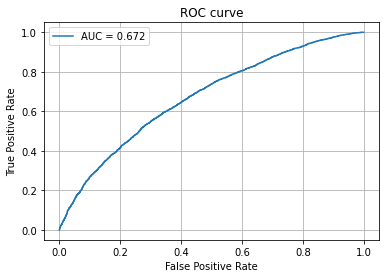

In [100]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=250)
)

# 学習
pipe.fit(X_train, y_train)

# ROC曲線
pred = pipe.predict_proba(X_val)[:, 1]         # 1の確率だけ取り出し

fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.6224572004028197


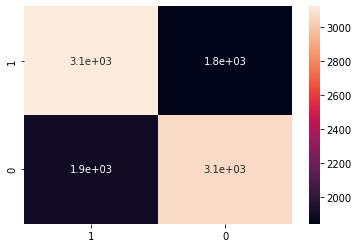

In [101]:
# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pipe.predict(X_val)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [102]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pipe.predict_proba(X_test)[:, 1]
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

#test2

In [103]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# SK_ID_CURR削除
## 追加：DAYS_EMPLOYED削除
df_t = df_t.drop(['SK_ID_CURR', 'DAYS_EMPLOYED'], axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

# posiとnegaのサンプル数を揃える
posi = df_t[df_t["TARGET"]==1]
nega = df_t[df_t["TARGET"]==0]
test = df_t[df_t["TARGET"].isnull()]

print("返済が滞ったことがある人:", len(posi))
print("返済をしっかりしている人:", len(nega))

nega = nega.sample(len(posi), random_state=500)
print(len(nega) + len(posi) + len(test))

df_t = pd.concat([posi, nega, test])
df_t["TARGET"].isnull().sum()

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 53)
(356255, 142)
返済が滞ったことがある人: 24825
返済をしっかりしている人: 282686
98394


48744

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

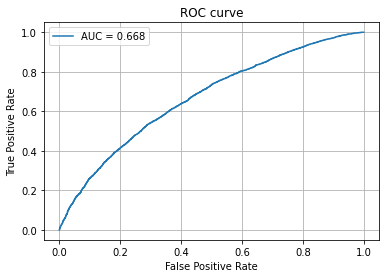

In [104]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=250)
)

# 学習
pipe.fit(X_train, y_train)

# ROC曲線
pred = pipe.predict_proba(X_val)[:, 1]         # 1の確率だけ取り出し

fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.6198388721047331


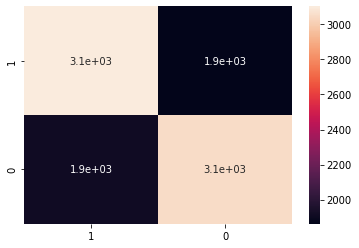

In [105]:
# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pipe.predict(X_val)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [106]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pipe.predict_proba(X_test)[:, 1]
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

#test3

In [107]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# SK_ID_CURR削除
## 追加：REG_REGION_NOT_WORK_REGION削除
df_t = df_t.drop(['SK_ID_CURR', 'REG_REGION_NOT_WORK_REGION'], axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

# posiとnegaのサンプル数を揃える
posi = df_t[df_t["TARGET"]==1]
nega = df_t[df_t["TARGET"]==0]
test = df_t[df_t["TARGET"].isnull()]

print("返済が滞ったことがある人:", len(posi))
print("返済をしっかりしている人:", len(nega))

nega = nega.sample(len(posi), random_state=500)
print(len(nega) + len(posi) + len(test))

df_t = pd.concat([posi, nega, test])
df_t["TARGET"].isnull().sum()

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 53)
(356255, 142)
返済が滞ったことがある人: 24825
返済をしっかりしている人: 282686
98394


48744

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

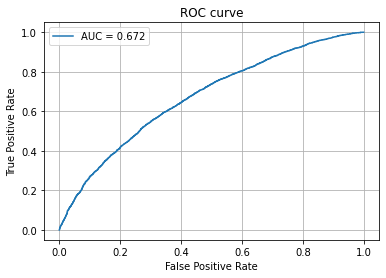

In [108]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=250)
)

# 学習
pipe.fit(X_train, y_train)

# ROC曲線
pred = pipe.predict_proba(X_val)[:, 1]         # 1の確率だけ取り出し

fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.6220543806646526


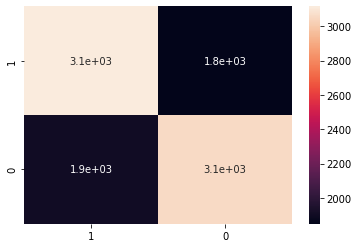

In [109]:
# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pipe.predict(X_val)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [110]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pipe.predict_proba(X_test)[:, 1]
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

# test4

In [111]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# SK_ID_CURR削除
## 追加：REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY削除
df_t = df_t.drop(['SK_ID_CURR', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'], axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

# posiとnegaのサンプル数を揃える
posi = df_t[df_t["TARGET"]==1]
nega = df_t[df_t["TARGET"]==0]
test = df_t[df_t["TARGET"].isnull()]

print("返済が滞ったことがある人:", len(posi))
print("返済をしっかりしている人:", len(nega))

nega = nega.sample(len(posi), random_state=500)
print(len(nega) + len(posi) + len(test))

df_t = pd.concat([posi, nega, test])
df_t["TARGET"].isnull().sum()

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 52)
(356255, 141)
返済が滞ったことがある人: 24825
返済をしっかりしている人: 282686
98394


48744

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

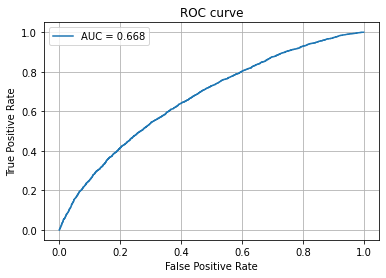

In [112]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=250)
)

# 学習
pipe.fit(X_train, y_train)

# ROC曲線
pred = pipe.predict_proba(X_val)[:, 1]         # 1の確率だけ取り出し

fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.6197381671701914


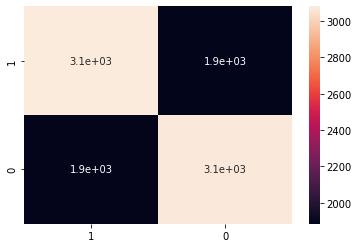

In [113]:
# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pipe.predict(X_val)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [114]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pipe.predict_proba(X_test)[:, 1]
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

#test5

In [115]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# 追記：EXT_SOURCE_1も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_1"] = df["EXT_SOURCE_1"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_1"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_1"] = df_t["EXT_SOURCE_1"].fillna(val)

# SK_ID_CURR削除
df_t = df_t.drop('SK_ID_CURR', axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

# posiとnegaのサンプル数を揃える
posi = df_t[df_t["TARGET"]==1]
nega = df_t[df_t["TARGET"]==0]
test = df_t[df_t["TARGET"].isnull()]

print("返済が滞ったことがある人:", len(posi))
print("返済をしっかりしている人:", len(nega))

nega = nega.sample(len(posi), random_state=500)
print(len(nega) + len(posi) + len(test))

df_t = pd.concat([posi, nega, test])
df_t["TARGET"].isnull().sum()

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 55)
(356255, 144)
返済が滞ったことがある人: 24825
返済をしっかりしている人: 282686
98394


48744

49650


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

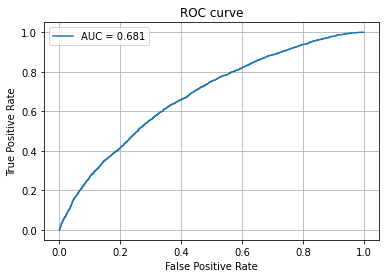

In [116]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)
print(len(tmp_train))

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=250)
)

# 学習
pipe.fit(X_train, y_train)

# ROC曲線
pred = pipe.predict_proba(X_val)[:, 1]         # 1の確率だけ取り出し

fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.6308157099697885


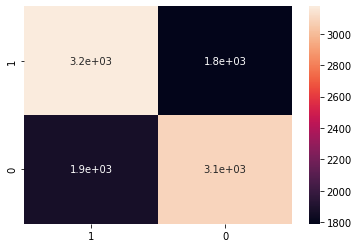

In [117]:
# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pipe.predict(X_val)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [118]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pipe.predict_proba(X_test)[:, 1]
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

#test6

In [119]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# 追記：EXT_SOURCE_1も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_1"] = df["EXT_SOURCE_1"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_1"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_1"] = df_t["EXT_SOURCE_1"].fillna(val)

# 追記：EXT_SOURCE_3も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_3"] = df["EXT_SOURCE_3"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_3"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_3"] = df_t["EXT_SOURCE_3"].fillna(val)

# SK_ID_CURR削除
df_t = df_t.drop('SK_ID_CURR', axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

# posiとnegaのサンプル数を揃える
posi = df_t[df_t["TARGET"]==1]
nega = df_t[df_t["TARGET"]==0]
test = df_t[df_t["TARGET"].isnull()]

print("返済が滞ったことがある人:", len(posi))
print("返済をしっかりしている人:", len(nega))

nega = nega.sample(len(posi), random_state=500)
print(len(nega) + len(posi) + len(test))

df_t = pd.concat([posi, nega, test])
df_t["TARGET"].isnull().sum()

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 56)
(356255, 145)
返済が滞ったことがある人: 24825
返済をしっかりしている人: 282686
98394


48744

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

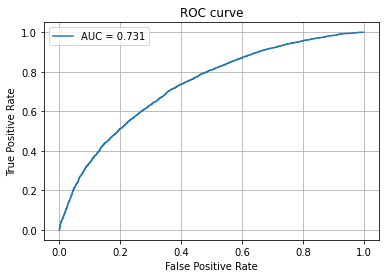

In [120]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=250)
)

# 学習
pipe.fit(X_train, y_train)

# ROC曲線
pred = pipe.predict_proba(X_val)[:, 1]         # 1の確率だけ取り出し

fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.6680765357502517


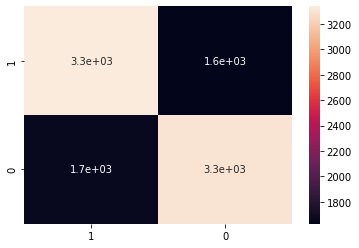

In [121]:
# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pipe.predict(X_val)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [122]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pipe.predict_proba(X_test)[:, 1]
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

#test7

In [123]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# 追記：EXT_SOURCE_1も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_1"] = df["EXT_SOURCE_1"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_1"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_1"] = df_t["EXT_SOURCE_1"].fillna(val)

# 追記：EXT_SOURCE_2も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_2"] = df["EXT_SOURCE_2"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_2"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_2"] = df_t["EXT_SOURCE_2"].fillna(val)

# 追記：EXT_SOURCE_3も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_3"] = df["EXT_SOURCE_3"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_3"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_3"] = df_t["EXT_SOURCE_3"].fillna(val)

# SK_ID_CURR削除
df_t = df_t.drop('SK_ID_CURR', axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

# posiとnegaのサンプル数を揃える
posi = df_t[df_t["TARGET"]==1]
nega = df_t[df_t["TARGET"]==0]
test = df_t[df_t["TARGET"].isnull()]

print("返済が滞ったことがある人:", len(posi))
print("返済をしっかりしている人:", len(nega))

nega = nega.sample(len(posi), random_state=500)
print(len(nega) + len(posi) + len(test))

df_t = pd.concat([posi, nega, test])
df_t["TARGET"].isnull().sum()

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 57)
(356255, 146)
返済が滞ったことがある人: 24825
返済をしっかりしている人: 282686
98394


48744

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

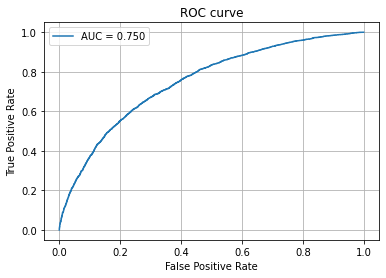

In [124]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=250)
)

# 学習
pipe.fit(X_train, y_train)

# ROC曲線
pred = pipe.predict_proba(X_val)[:, 1]         # 1の確率だけ取り出し

fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.6836858006042296


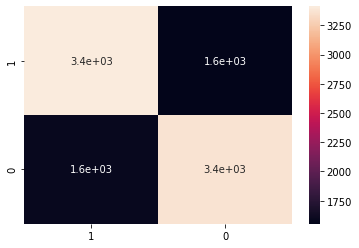

In [125]:
# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pipe.predict(X_val)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [126]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pipe.predict_proba(X_test)[:, 1]
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

#test8

In [127]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# 追記：EXT_SOURCE_1も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_1"] = df["EXT_SOURCE_1"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_1"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_1"] = df_t["EXT_SOURCE_1"].fillna(val)

# 追記：EXT_SOURCE_2も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_2"] = df["EXT_SOURCE_2"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_2"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_2"] = df_t["EXT_SOURCE_2"].fillna(val)

# 追記：EXT_SOURCE_3も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_3"] = df["EXT_SOURCE_3"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_3"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_3"] = df_t["EXT_SOURCE_3"].fillna(val)

# 追記：AMT_ANNUITYも再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["AMT_ANNUITY"] = df["AMT_ANNUITY"].copy()
val = df_t[df_t["TARGET"].notnull()]["AMT_ANNUITY"].mean() # trainデータ内で算出
df_t["AMT_ANNUITY"] = df_t["AMT_ANNUITY"].fillna(val)

# SK_ID_CURR削除
df_t = df_t.drop('SK_ID_CURR', axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

# posiとnegaのサンプル数を揃える
posi = df_t[df_t["TARGET"]==1]
nega = df_t[df_t["TARGET"]==0]
test = df_t[df_t["TARGET"].isnull()]

print("返済が滞ったことがある人:", len(posi))
print("返済をしっかりしている人:", len(nega))

nega = nega.sample(len(posi), random_state=500)
print(len(nega) + len(posi) + len(test))

df_t = pd.concat([posi, nega, test])
df_t["TARGET"].isnull().sum()

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 58)
(356255, 147)
返済が滞ったことがある人: 24825
返済をしっかりしている人: 282686
98394


48744

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

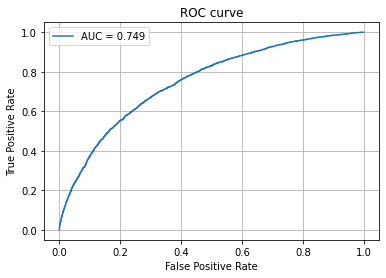

In [128]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=250)
)

# 学習
pipe.fit(X_train, y_train)

# ROC曲線
pred = pipe.predict_proba(X_val)[:, 1]         # 1の確率だけ取り出し

fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.6850956696878147


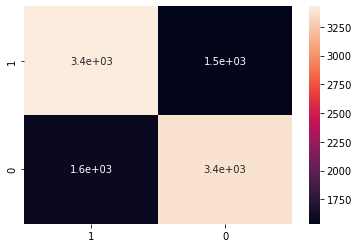

In [129]:
# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pipe.predict(X_val)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [130]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pipe.predict_proba(X_test)[:, 1]
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

#test9

In [131]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# 追記：EXT_SOURCE_1も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_1"] = df["EXT_SOURCE_1"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_1"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_1"] = df_t["EXT_SOURCE_1"].fillna(val)

# 追記：EXT_SOURCE_2も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_2"] = df["EXT_SOURCE_2"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_2"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_2"] = df_t["EXT_SOURCE_2"].fillna(val)

# 追記：EXT_SOURCE_3も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_3"] = df["EXT_SOURCE_3"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_3"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_3"] = df_t["EXT_SOURCE_3"].fillna(val)

# 追記：AMT_ANNUITYも再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["AMT_ANNUITY"] = df["AMT_ANNUITY"].copy()
val = df_t[df_t["TARGET"].notnull()]["AMT_ANNUITY"].mean() # trainデータ内で算出
df_t["AMT_ANNUITY"] = df_t["AMT_ANNUITY"].fillna(val)

# SK_ID_CURR削除
df_t = df_t.drop('SK_ID_CURR', axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 58)
(356255, 147)


In [132]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

print(X_train.shape)
print(X_val.shape)

(246008, 146)
(61503, 146)


In [133]:
import warnings
warnings.simplefilter('ignore')     # iterが少ないという警告を無視

# posi-negaのサンプルサイズを調整するために再結合
tmp = X_train.copy()
tmp["TARGET"] = y_train

tmp_posi = tmp[tmp["TARGET"]==1]
tmp_nega = tmp[tmp["TARGET"]==0]

print("posiの数:", len(tmp_posi))
print("negaの数:", len(tmp_nega))
print("全データ:", len(tmp_nega)+len(tmp_posi))
print("negaはposiの約", int(len(tmp_nega) / len(tmp_posi)), "倍のデータ数")
print("合計サンプル数:", len(tmp_posi)*10 + len(tmp_nega))

# negaを10分割して、それぞれをposiと結合し10個のデータセットを作成
kf = KFold(n_splits=10, shuffle=True, random_state=500)
i = 0
train_list = []

for _, index in kf.split(tmp_nega):
    train_list.append(pd.concat([tmp_nega.iloc[index], tmp_posi], ignore_index=True, sort=False))


# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=250)
)

# モデル10個作成
model_list = []

for i in range(len(train_list)):
    tmp_train = train_list[i]
    X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
    y = tmp_train.TARGET

    # 学習
    model_list.append(pipe.fit(X, y))

warnings.resetwarnings()
len(model_list)

posiの数: 19860
negaの数: 226148
全データ: 246008
negaはposiの約 11 倍のデータ数
合計サンプル数: 424748


10

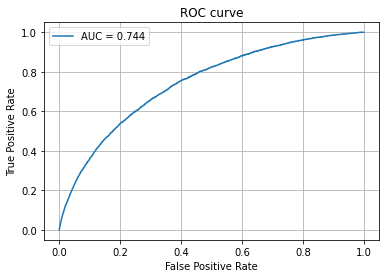

In [134]:
def pred_proba(X_test, model_list):
    pred_list = []
    for i in range(len(model_list)):
        pred_list.append(model_list[i].predict_proba(X_test)[:, 1])

    p = np.array(pred_list)
    p = np.mean(p, axis = 0)
    return p

pred = pred_proba(X_val, model_list)

# ROC曲線
fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.7217859291416678


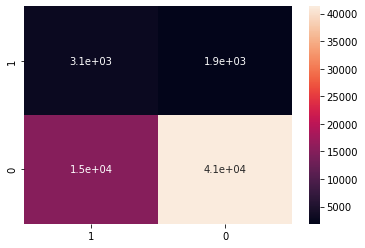

In [135]:
def pred(X_test, model_list):
    p = pred_proba(X_test, model_list)
    return np.where(p < 0.5, 0, 1)

# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pred(X_val, model_list)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [136]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pred_proba(X_test, model_list)
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

#test10

In [137]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# 追記：EXT_SOURCE_1も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_1"] = df["EXT_SOURCE_1"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_1"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_1"] = df_t["EXT_SOURCE_1"].fillna(val)

# 追記：EXT_SOURCE_2も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_2"] = df["EXT_SOURCE_2"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_2"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_2"] = df_t["EXT_SOURCE_2"].fillna(val)

# 追記：EXT_SOURCE_3も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_3"] = df["EXT_SOURCE_3"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_3"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_3"] = df_t["EXT_SOURCE_3"].fillna(val)

# 追記：AMT_ANNUITYも再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["AMT_ANNUITY"] = df["AMT_ANNUITY"].copy()
val = df_t[df_t["TARGET"].notnull()]["AMT_ANNUITY"].mean() # trainデータ内で算出
df_t["AMT_ANNUITY"] = df_t["AMT_ANNUITY"].fillna(val)

# SK_ID_CURR削除
df_t = df_t.drop('SK_ID_CURR', axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 58)
(356255, 147)


In [138]:
# PCA check
X_tmp = df_t[df_t.columns[df_t.columns != 'TARGET']]

ss = StandardScaler()
X_std = ss.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_std)

print("情報少ないデータの目安:", 1 / df_t.shape[1])
#np.cumsum(pca.explained_variance_ratio_)
np.count_nonzero(pca.explained_variance_ratio_ > (1 / df_t.shape[1]))

情報少ないデータの目安: 0.006802721088435374


99

In [139]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

print(X_train.shape)
print(X_val.shape)

(246008, 146)
(61503, 146)


In [140]:
import warnings
warnings.simplefilter('ignore')     # iterが少ないという警告を無視

# posi-negaのサンプルサイズを調整するために再結合
tmp = X_train.copy()
tmp["TARGET"] = y_train

tmp_posi = tmp[tmp["TARGET"]==1]
tmp_nega = tmp[tmp["TARGET"]==0]

print("posiの数:", len(tmp_posi))
print("negaの数:", len(tmp_nega))
print("全データ:", len(tmp_nega)+len(tmp_posi))
print("negaはposiの約", int(len(tmp_nega) / len(tmp_posi)), "倍のデータ数")
print("合計サンプル数:", len(tmp_posi)*10 + len(tmp_nega))

# negaを10分割して、それぞれをposiと結合し10個のデータセットを作成
kf = KFold(n_splits=10, shuffle=True, random_state=500)
i = 0
train_list = []

for _, index in kf.split(tmp_nega):
    train_list.append(pd.concat([tmp_nega.iloc[index], tmp_posi], ignore_index=True, sort=False))


# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        PCA(n_components=100),
        LogisticRegression(max_iter=250)
)

# モデル10個作成
model_list = []

for i in range(len(train_list)):
    tmp_train = train_list[i]
    X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
    y = tmp_train.TARGET

    # 学習
    model_list.append(pipe.fit(X, y))

warnings.resetwarnings()
len(model_list)

posiの数: 19860
negaの数: 226148
全データ: 246008
negaはposiの約 11 倍のデータ数
合計サンプル数: 424748


10

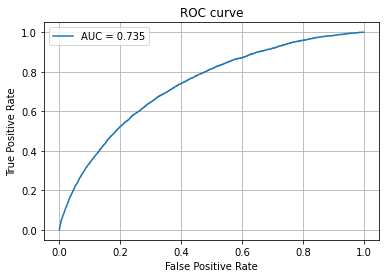

In [141]:
def pred_proba(X_test, model_list):
    pred_list = []
    for i in range(len(model_list)):
        pred_list.append(model_list[i].predict_proba(X_test)[:, 1])

    p = np.array(pred_list)
    p = np.mean(p, axis = 0)
    return p

pred = pred_proba(X_val, model_list)

# ROC曲線
fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.7156724062240867


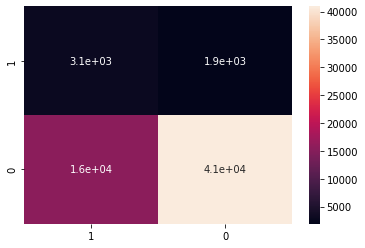

In [142]:
def pred(X_test, model_list):
    p = pred_proba(X_test, model_list)
    return np.where(p < 0.5, 0, 1)

# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pred(X_val, model_list)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [143]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pred_proba(X_test, model_list)
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

# test11

In [144]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# 追記：EXT_SOURCE_1も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_1"] = df["EXT_SOURCE_1"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_1"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_1"] = df_t["EXT_SOURCE_1"].fillna(val)

# 追記：EXT_SOURCE_2も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_2"] = df["EXT_SOURCE_2"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_2"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_2"] = df_t["EXT_SOURCE_2"].fillna(val)

# 追記：EXT_SOURCE_3も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_3"] = df["EXT_SOURCE_3"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_3"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_3"] = df_t["EXT_SOURCE_3"].fillna(val)

# 追記：AMT_ANNUITYも再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["AMT_ANNUITY"] = df["AMT_ANNUITY"].copy()
val = df_t[df_t["TARGET"].notnull()]["AMT_ANNUITY"].mean() # trainデータ内で算出
df_t["AMT_ANNUITY"] = df_t["AMT_ANNUITY"].fillna(val)

# 追記：DAYS_EMPLOYED内の365243は外れ値
# 一度NaNに変換してから、trainデータの平均値に置き換え
df_t["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)
val = df_t[df_t["TARGET"].notnull()]["DAYS_EMPLOYED"].mean() # trainデータ内で算出
df_t["DAYS_EMPLOYED"] = df_t["DAYS_EMPLOYED"].fillna(val)


# SK_ID_CURR削除
df_t = df_t.drop('SK_ID_CURR', axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

df_t["DAYS_EMPLOYED"].isnull().sum()

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 58)
(356255, 147)


0

In [145]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

print(X_train.shape)
print(X_val.shape)

(246008, 146)
(61503, 146)


In [146]:
import warnings
warnings.simplefilter('ignore')     # iterが少ないという警告を無視

# posi-negaのサンプルサイズを調整するために再結合
tmp = X_train.copy()
tmp["TARGET"] = y_train

tmp_posi = tmp[tmp["TARGET"]==1]
tmp_nega = tmp[tmp["TARGET"]==0]

print("posiの数:", len(tmp_posi))
print("negaの数:", len(tmp_nega))
print("全データ:", len(tmp_nega)+len(tmp_posi))
print("negaはposiの約", int(len(tmp_nega) / len(tmp_posi)), "倍のデータ数")
print("合計サンプル数:", len(tmp_posi)*10 + len(tmp_nega))

# negaを10分割して、それぞれをposiと結合し10個のデータセットを作成
kf = KFold(n_splits=10, shuffle=True, random_state=500)
i = 0
train_list = []

for _, index in kf.split(tmp_nega):
    train_list.append(pd.concat([tmp_nega.iloc[index], tmp_posi], ignore_index=True, sort=False))


# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=250)
)

# モデル10個作成
model_list = []

for i in range(len(train_list)):
    tmp_train = train_list[i]
    X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
    y = tmp_train.TARGET

    # 学習
    model_list.append(pipe.fit(X, y))

warnings.resetwarnings()
len(model_list)

posiの数: 19860
negaの数: 226148
全データ: 246008
negaはposiの約 11 倍のデータ数
合計サンプル数: 424748


10

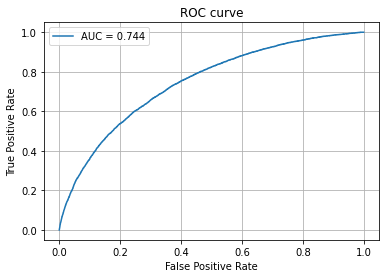

In [147]:
def pred_proba(X_test, model_list):
    pred_list = []
    for i in range(len(model_list)):
        pred_list.append(model_list[i].predict_proba(X_test)[:, 1])

    p = np.array(pred_list)
    p = np.mean(p, axis = 0)
    return p

pred = pred_proba(X_val, model_list)

# ROC曲線
fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.7206965513877371


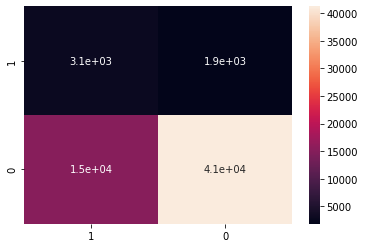

In [148]:
def pred(X_test, model_list):
    p = pred_proba(X_test, model_list)
    return np.where(p < 0.5, 0, 1)

# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pred(X_val, model_list)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [149]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pred_proba(X_test, model_list)
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )

#test12

In [150]:
print(df.shape)

# 欠損値含む列削除
df_t = df.dropna(how='any', axis=1).copy()  # ここでcopy()が無いと次のTARGETの挿入時に警告が出る
print(df_t.shape)

# TARGETも削除されたので再挿入
df_t["TARGET"] = df["TARGET"].copy()
print(df_t.shape)

# 追記：EXT_SOURCE_1も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_1"] = df["EXT_SOURCE_1"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_1"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_1"] = df_t["EXT_SOURCE_1"].fillna(val)

# 追記：EXT_SOURCE_2も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_2"] = df["EXT_SOURCE_2"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_2"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_2"] = df_t["EXT_SOURCE_2"].fillna(val)

# 追記：EXT_SOURCE_3も再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["EXT_SOURCE_3"] = df["EXT_SOURCE_3"].copy()
val = df_t[df_t["TARGET"].notnull()]["EXT_SOURCE_3"].mean() # trainデータ内で算出
df_t["EXT_SOURCE_3"] = df_t["EXT_SOURCE_3"].fillna(val)

# 追記：AMT_ANNUITYも再挿入
# 欠損値はtrainデータの平均値に置き換え
df_t["AMT_ANNUITY"] = df["AMT_ANNUITY"].copy()
val = df_t[df_t["TARGET"].notnull()]["AMT_ANNUITY"].mean() # trainデータ内で算出
df_t["AMT_ANNUITY"] = df_t["AMT_ANNUITY"].fillna(val)

# 追記：DAYS_EMPLOYED内の365243は外れ値
# 一度NaNに変換してから、trainデータの平均値に置き換え
df_t["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)
val = df_t[df_t["TARGET"].notnull()]["DAYS_EMPLOYED"].mean() # trainデータ内で算出
df_t["DAYS_EMPLOYED"] = df_t["DAYS_EMPLOYED"].fillna(val)

# 追記：['DAYS_EMPLOYED'] / ['DAYS_BIRTH'] 作成
df_t["DAYS_EMPLOYED_PER"] = df_t["DAYS_EMPLOYED"] / df_t["DAYS_BIRTH"]
df_t = df_t.drop(["DAYS_EMPLOYED", "DAYS_BIRTH"], axis=1)

# SK_ID_CURR削除
df_t = df_t.drop('SK_ID_CURR', axis=1)
print(df_t.shape)

# ワンホットエンコーディング
df_t = pd.get_dummies(
        df_t,
        drop_first=True,
        dummy_na=True
         )
print(df_t.shape)

df_t["DAYS_EMPLOYED_PER"].isnull().sum()

(356255, 122)
(356255, 54)
(356255, 55)
(356255, 57)
(356255, 146)


0

In [151]:
# train-test分離
tmp_train = df_t[df_t['TARGET'].notnull()]
tmp_test = df_t[df_t['TARGET'].isnull()].drop('TARGET', axis=1)

# trainのX-y分離
X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
y = tmp_train.TARGET

# train-validation分離
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=500, test_size=0.2, stratify=y)

print(X_train.shape)
print(X_val.shape)

(246008, 145)
(61503, 145)


In [152]:
import warnings
warnings.simplefilter('ignore')     # iterが少ないという警告を無視

# posi-negaのサンプルサイズを調整するために再結合
tmp = X_train.copy()
tmp["TARGET"] = y_train

tmp_posi = tmp[tmp["TARGET"]==1]
tmp_nega = tmp[tmp["TARGET"]==0]

print("posiの数:", len(tmp_posi))
print("negaの数:", len(tmp_nega))
print("全データ:", len(tmp_nega)+len(tmp_posi))
print("negaはposiの約", int(len(tmp_nega) / len(tmp_posi)), "倍のデータ数")
print("合計サンプル数:", len(tmp_posi)*10 + len(tmp_nega))

# negaを10分割して、それぞれをposiと結合し10個のデータセットを作成
kf = KFold(n_splits=10, shuffle=True, random_state=500)
i = 0
train_list = []

for _, index in kf.split(tmp_nega):
    train_list.append(pd.concat([tmp_nega.iloc[index], tmp_posi], ignore_index=True, sort=False))


# インスタンス化
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=250)
)

# モデル10個作成
model_list = []

for i in range(len(train_list)):
    tmp_train = train_list[i]
    X = tmp_train[tmp_train.columns[tmp_train.columns != 'TARGET']]
    y = tmp_train.TARGET

    # 学習
    model_list.append(pipe.fit(X, y))

warnings.resetwarnings()
len(model_list)

posiの数: 19860
negaの数: 226148
全データ: 246008
negaはposiの約 11 倍のデータ数
合計サンプル数: 424748


10

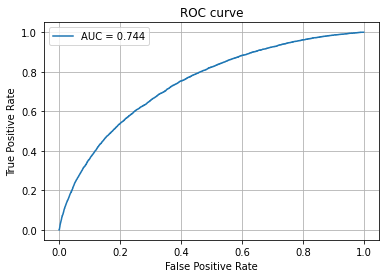

In [153]:
def pred_proba(X_test, model_list):
    pred_list = []
    for i in range(len(model_list)):
        pred_list.append(model_list[i].predict_proba(X_test)[:, 1])

    p = np.array(pred_list)
    p = np.mean(p, axis = 0)
    return p

pred = pred_proba(X_val, model_list)

# ROC曲線
fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)         # ROC曲線からAUCを算出

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

acc: 0.7209079231907387


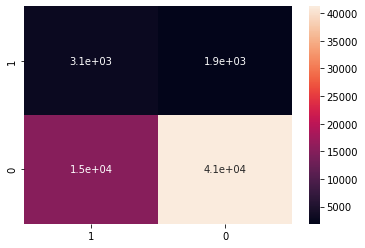

In [154]:
def pred(X_test, model_list):
    p = pred_proba(X_test, model_list)
    return np.where(p < 0.5, 0, 1)

# classを予測する predの0.5を閾値に分類したものと等価）
pred_class = pred(X_val, model_list)

print('acc:', accuracy_score(y_val, pred_class))

# 混同行列をプロット
classes = [1, 0]
cm = confusion_matrix(y_val, pred_class, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
sns.heatmap(cmdf, annot=True)

In [155]:
submit = pd.read_csv("/content/sample_submission.csv")

X_test = tmp_test[tmp_test.columns[tmp_test.columns != 'TARGET']]

submit["TARGET"] = pred_proba(X_test, model_list)
submit.to_csv(
    "/content/drive/MyDrive/project/Kaggle_Home-Credit-Default-Risk/submission.csv",
    index=False
    )